## Thermostatic conditions of typical indoor environments

In [1]:
%matplotlib notebook 
%matplotlib inline

## Imports:

In [2]:
import h5py
import numpy as np
import pandas
import pylab
import math

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, FixedLocator
from matplotlib.legend_handler import HandlerLine2D

## Available h5 data files (in data folder):
### One-bedroom flat (Glasgow, UK)
### 5 freefloating simulations for different months and 2 different HVAC strategies 
### (basic air node heat injection vs radiant walls)

In [4]:
tenFlat_free_Feb = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_5-11Feb_compoundFull.h5'

In [5]:
tenFlat_free_Nov = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_15-21Nov_compoundFull.h5'

In [6]:
tenFlat_free_Mar = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_15-21Mar_compoundFull.h5'

In [7]:
tenFlat_free_Jul = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_17-23Jul_compoundFull.h5'

In [8]:
tenFlat_free_SepOct = '../../data/h5_from_espr/free_floating/exergyResults_tenFlat_freeFloat_29Sep-5Oct_compoundFull.h5'

In [9]:
tenFlatHIns_unconstrained_Feb = '../../data/h5_from_espr/h_ins/exergyResults_tenFlat_hIns_5-11Feb_compoundFull_unconstrainedControl.h5'

In [10]:
tenFlatHIns_basicControl_Feb = '../../data/h5_from_espr/h_ins/exergyResults_tenFlat_hIns_5-11Feb_compoundFull_BasicControl.h5'

### Lists of datasets:

In [11]:
freefloating_file_list = [tenFlat_free_Feb, tenFlat_free_Nov, tenFlat_free_Mar, tenFlat_free_Jul, tenFlat_free_SepOct]

In [12]:
hvac_file_list = [tenFlatHIns_unconstrained_Feb, tenFlatHIns_basicControl_Feb]

### Define a function used to scan the file stucture:

In [13]:
from __future__ import print_function

def scan_hdf5(path, recursive=True, tab_step=2):
    def scan_node(g, tabs=0):
        print(' ' * tabs, g.name)
        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                print(' ' * tabs + ' ' * tab_step + ' -', v.name)
            elif isinstance(v, h5py.Group) and recursive:
                scan_node(v, tabs=tabs + tab_step)
    with h5py.File(path, 'r') as f:
        scan_node(f)

In [14]:
# free floating files structure
scan_hdf5(tenFlat_free_Feb)

 /
   /01
     - /01/layer_values
     - /01/temperatures
   /02
     - /02/layer_values
     - /02/temperatures
   /03
     - /03/layer_values
     - /03/temperatures
   /04
     - /04/layer_values
     - /04/temperatures


In [15]:
# hvac files structure
scan_hdf5(tenFlatHIns_basicControl_Feb)

 /
   /01
     - /01/layer_values
     - /01/temperatures
   /02
     - /02/layer_values
     - /02/temperatures
   /03
     - /03/layer_values
     - /03/temperatures
   /04
     - /04/layer_values
     - /04/temperatures
   /05
     - /05/layer_values
     - /05/temperatures


### layer_values: 
contains the properties of each construction layer (or volume of air) and the average layer temperature; 

### temperatures:
contains the temperature (in deg C) of each node (each layer has 3 nodes, the boundary nodes are shared between adjacent layers)

## Open the desired hdf5 file and call it f
### (names and paths above, copy the desidered name in the next function) 

In [16]:
f = h5py.File(tenFlatHIns_unconstrained_Feb,'r')

### check the structure of the file by listing its keys:

In [17]:
list(f.keys())

['01', '02', '03', '04', '05']

In [18]:
list(f['/01'].keys())

['layer_values', 'temperatures']

In [19]:
# not sure how I can get the structure of the compound data inside... find out!
# list(f['/01/layer_values'].fields)

### Define a more convenient name for the relevant datasets:

In [20]:
zone01=f['/01']

In [21]:
zone02=f['/02']

In [22]:
zone03=f['/03']

In [23]:
layers_01=f['/01/layer_values']

In [24]:
temperatures_01=f['/01/temperatures']

In [25]:
layers_02=f['/02/layer_values']

In [26]:
temperatures_02=f['/02/temperatures']

In [27]:
layers_03=f['/03/layer_values']

In [28]:
temperatures_03=f['/03/temperatures']

### Check if possible to retrieve a value, e.g. the conductivity k of layer 1, surface 1, zone 01 at timestep 1:

#### Format: layers_zone(layer,surface,timestep)

In [29]:
#indexes of zone dataset: layer,surface,timestep
layers_01[1,1,1]['k']

0.84

# ZONE: number of dataset

In [30]:
zone_dataset = layers_01

## CALCULATE THE THERMOSTATIC TEMPERATURE AT EACH TIMESTEP (here called 'dead_T' for brevity), INCLUDING ONLY 10CM OF INNER LAYERS

### 1. for a specific timestep (hour) of a dataset:

In [31]:
def calculate_dead_T(time,dataset):
    dead_T = 0.0
    dead_T_numerator = 0.0
    dead_T_denominator = 0.0
    for surf in range(0,dataset.shape[1]-2):
        total_thickness_included = 0
        for layer in range(0,dataset.shape[0]):
            if total_thickness_included >= 0.10000:
                break
            if dataset[layer,surf,time]['k'] < 0.06:
                break
            if (total_thickness_included + dataset[layer][surf][time]['th']) <= 0.10000:
                total_thickness_included += dataset[layer][surf][time]['th']
                # and add the contribution with full thickness
                dead_T_numerator += dataset[layer][surf][time]['d']*dataset[layer][surf][time]['th']*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']*dataset[layer][surf][time]['T']
                dead_T_denominator += dataset[layer][surf][time]['d']*dataset[layer][surf][time]['th']*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']
            else:
                partial_layer_th = 0.10000 - total_thickness_included
                total_thickness_included = 0.10000
                # and add the contribution with partial thickness
                dead_T_numerator += dataset[layer][surf][time]['d']*partial_layer_th*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']*dataset[layer][surf][time]['T']
                dead_T_denominator += dataset[layer][surf][time]['d']*partial_layer_th*dataset[layer][surf][time]['A']*dataset[layer][surf][time]['c']

    dead_T = dead_T_numerator/dead_T_denominator
    return dead_T   
        

### for example, at timestep 6 of the selected zone:

In [32]:
calculate_dead_T(6,zone_dataset)

20.385390924063774

### 2. same calculation, as a function of time:

In [33]:
def calculate_dead_T_array(dataset):
    dead_T_array = np.zeros(shape=dataset.shape[2],dtype=float)
    for time in range(0,dead_T_array.size):
        dead_T_array[time] = calculate_dead_T(time,dataset)
    return dead_T_array
        

In [34]:
deadTs = calculate_dead_T_array(zone_dataset)

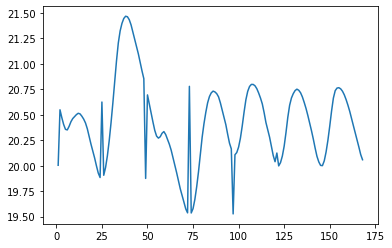

In [35]:
x_coordinate = [ i+1 for i in range(len(deadTs)) ]
plt.plot(x_coordinate,deadTs)
plt.savefig('../../results/example_thermostatic_plot.png')

## Produce figures for all the zones in one file

In [ ]:
file_num = 0
for file in hvac_file_list:
    
    file_num = file_num + 1
    f = h5py.File(file,'r')
    
    zone_01=f['/01/layer_values'] # bedroom
    zone_02=f['/02/layer_values'] # living room
    zone_03=f['/03/layer_values'] # bathroom
    zone_04=f['/04/layer_values'] # loft
    zone_05=f['/05/layer_values'] # hall
    zone_datasets = [zone_01,zone_02,zone_03,zone_04,zone_05]
    
    z = 0
    for zone_dataset in zone_datasets:
        z = z+1
        deadTs = calculate_dead_T_array(zone_dataset)
        
        x_coordinate = [ i+1 for i in range(len(deadTs)) ]
        plt.plot(x_coordinate,deadTs)
        plt.savefig('../../results/'+str(file_num)+'_'+str(z)+'.png')